# **DCGAN ON PASCAL VOC 2008 DATASET**

## DATA LOADING

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import os
import random
from torchvision import datasets, transforms
from torchvision.utils import save_image
from scipy.stats import norm
from PIL import Image

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg
from sklearn.metrics import average_precision_score, accuracy_score, precision_recall_curve, auc
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from IPython.display import FileLink
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
import warnings

2024-04-22 14:21:35.237343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 14:21:35.237501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 14:21:35.376372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED = 42
IMAGES_DIR = "/kaggle/input/voc2008-genai-project-a-dataset/Images"
LABELS_DIR = "/kaggle/input/voc2008-labels/labels.csv"
# # OUT_MODELS_PATH = 'models'
# Primary metric used to evaluate the perfomance
def AP(y_true, y_pred):
    return tf.py_function(average_precision_score, [y_true, y_pred], tf.float32)

def plot_images(image_paths, dims, figsize, image_labels):
    fig, axes = plt.subplots(dims[0], dims[1], figsize=figsize)

    for i, ax in enumerate(axes.flatten()):
        if i < len(image_paths):
            ax.imshow(mpimg.imread(image_paths[i]))
            ax.set_title(f"score: {image_labels[i]}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# It gives warning when a batch does not have any positives which is quite often
warnings.filterwarnings("ignore", message="No positive class found in y_true, recall is set to one for all thresholds.")
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
df = pd.read_csv(LABELS_DIR)
labels = np.array([col for col in df.columns if col not in ["path", "set"]])
df['path1'] = IMAGES_DIR + '/' + df['path']

In [5]:
# df.head(2)

In [6]:
# Create directories for train and val sets
train_dir = '/kaggle/working/images/train/'
val_dir = '/kaggle/working/images/val/'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Group images by set
grouped = df.groupby('set')

# Iterate over each group
for set_name, group_df in grouped:
    # Determine the directory to save images based on the set
    save_dir = train_dir if set_name == 'train' else val_dir

    # Create subdirectories for each label if they don't exist
    label_cols = [col for col in df.columns if col not in ['path1', 'set']]
    for label in label_cols:
        label_dir = os.path.join(save_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        # Filter images for this label and set
        label_images = group_df[group_df[label] == 1]

        # Iterate over each image for this label and set
        for i, image_path in enumerate(label_images['path1']):
            # Open the image
            img = Image.open(image_path)

            # Generate a unique name for each image
            image_name = f'image_{i}.jpg'
            image_save_path = os.path.join(label_dir, image_name)

            # Save the image
            img.save(image_save_path)

In [7]:
label = list(labels)####

In [8]:
label

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [9]:
# Define a custom dataset class to exclude UL (unhealthy leaves) data
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, hl_class=None):
        self.root_dir = root_dir
        self.transform = transform
        self.hl_class = hl_class  # Specify the class for healthy leaves
        self.classes = os.listdir(root_dir)

        self.data = []
        self.targets = []

        for i, cls in enumerate(self.classes):
            class_dir = os.path.join(root_dir, cls)
            # Only consider data from the specified class (HL)
            if cls == self.hl_class:
                for filename in os.listdir(class_dir):
                    self.data.append(os.path.join(class_dir, filename))
                    self.targets.append(i)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert("RGB")  # Adjust conversion if needed
        label = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize if needed
    transforms.ToTensor()
])


In [10]:
train_dir = '/kaggle/working/images'
val_dir = '/kaggle/working/images'

label_train_datasets = {}  # Dictionary to store train datasets for each label
label_test_datasets = {}   # Dictionary to store test datasets for each label

for i in label:  # Iterate over your list of labels
    train_dataset = CustomDataset(os.path.join(train_dir, 'train'), transform=transform, hl_class=i)
    test_dataset = CustomDataset(os.path.join(val_dir, 'val'), transform=transform, hl_class=i)

    label_train_datasets[i] = train_dataset
    label_test_datasets[i] = test_dataset

In [11]:
label_train_datasets

{'aeroplane': <__main__.CustomDataset at 0x79d4ac4c4430>,
 'bicycle': <__main__.CustomDataset at 0x79d4ac4c7d60>,
 'bird': <__main__.CustomDataset at 0x79d4ac4c4400>,
 'boat': <__main__.CustomDataset at 0x79d4ac4c4fa0>,
 'bottle': <__main__.CustomDataset at 0x79d4ac4c6e30>,
 'bus': <__main__.CustomDataset at 0x79d4ac4c6620>,
 'car': <__main__.CustomDataset at 0x79d4ac4c6d40>,
 'cat': <__main__.CustomDataset at 0x79d4ac4c6bf0>,
 'chair': <__main__.CustomDataset at 0x79d4ac4c72b0>,
 'cow': <__main__.CustomDataset at 0x79d4ac4c7a00>,
 'diningtable': <__main__.CustomDataset at 0x79d4ac4c6e60>,
 'dog': <__main__.CustomDataset at 0x79d4ac4c4d00>,
 'horse': <__main__.CustomDataset at 0x79d4ac4c69b0>,
 'motorbike': <__main__.CustomDataset at 0x79d4ac4c6380>,
 'person': <__main__.CustomDataset at 0x79d4ac4c5ae0>,
 'pottedplant': <__main__.CustomDataset at 0x79d4ac4c73d0>,
 'sheep': <__main__.CustomDataset at 0x79d4ac4c73a0>,
 'sofa': <__main__.CustomDataset at 0x79d4ac4c5960>,
 'train': <__main

In [12]:
# !pip install torchvision

In [13]:
import os

DATA_DIR = '/kaggle/working/images/train'

print(os.listdir(DATA_DIR))

['pottedplant', 'cow', 'person', 'diningtable', 'train', 'sofa', 'dog', 'chair', 'car', 'bicycle', 'bird', 'horse', 'bus', 'motorbike', 'path', 'cat', 'bottle', 'tvmonitor', 'sheep', 'aeroplane', 'boat']


In [14]:
import shutil

folder_path = '/kaggle/working/images/train/path'  # Specify the path to the folder you want to delete

# Check if the folder exists
if os.path.exists(folder_path):
    # Remove the folder and its contents
    shutil.rmtree(folder_path)
    print(f"The folder at {folder_path} and its contents have been successfully deleted.")
else:
    print(f"The folder at {folder_path} does not exist.")


The folder at /kaggle/working/images/train/path and its contents have been successfully deleted.


In [15]:
print(os.listdir(DATA_DIR+'/bird')[:10])

['image_75.jpg', 'image_93.jpg', 'image_156.jpg', 'image_56.jpg', 'image_31.jpg', 'image_67.jpg', 'image_160.jpg', 'image_111.jpg', 'image_107.jpg', 'image_142.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

## DATA PRE-PROCESSING AND NECESSARY VARIABLE INITIALIZATIONS 

In [16]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [17]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [18]:
from torch.utils.data import Subset


In [19]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

for class_name in train_ds.classes:
    print(f"Training for class: {class_name}")
    # Filter dataset for the current class
    class_idx = train_ds.class_to_idx[class_name]
    indices = [i for i, (_, label) in enumerate(train_ds.imgs) if label == class_idx]
    class_subset = Subset(train_ds, indices)
    class_dl = DataLoader(class_subset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)


# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Training for class: aeroplane
Training for class: bicycle
Training for class: bird
Training for class: boat
Training for class: bottle
Training for class: bus
Training for class: car
Training for class: cat
Training for class: chair
Training for class: cow
Training for class: diningtable
Training for class: dog
Training for class: horse
Training for class: motorbike
Training for class: person
Training for class: pottedplant
Training for class: sheep
Training for class: sofa
Training for class: train
Training for class: tvmonitor


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [20]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [22]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

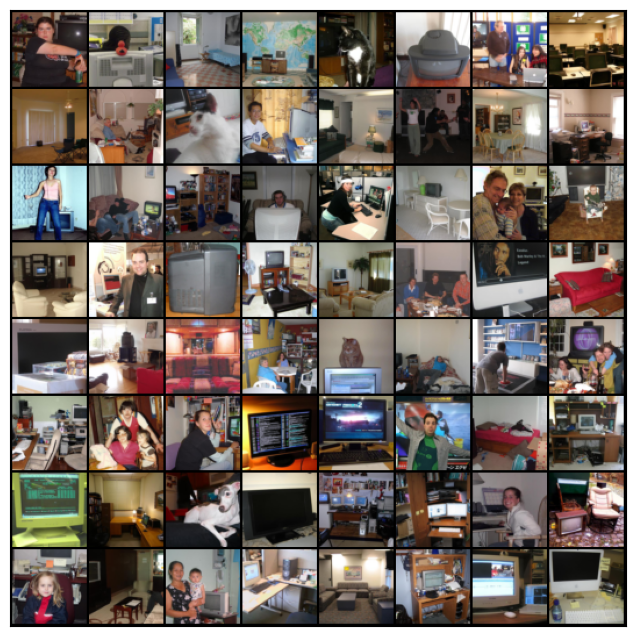

In [23]:
show_batch(class_dl)

In [24]:
# show_batch(train_dl)

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [26]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [27]:
class_dl = DeviceDataLoader(class_dl, device)

In [28]:
import torch.nn as nn

In [29]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [30]:
# # Load previously trained discriminator weights
# pretrained_dis = '/kaggle/working/final_D.pth'

# # Load pretrained weights into the generator model
# discriminator.load_state_dict(torch.load(pretrained_dis))

In [31]:
discriminator = to_device(discriminator, device)

In [32]:
latent_size = 120

In [33]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [35]:
# Load previously trained generator weights
pretrained_gen = '/kaggle/input/gan/pytorch/dcgans_model-improvements/7/VOC2012_generator_epoch_30.pt'

# Load pretrained weights into the generator model
generator.load_state_dict(torch.load(pretrained_gen))


<All keys matched successfully>

torch.Size([128, 3, 64, 64])


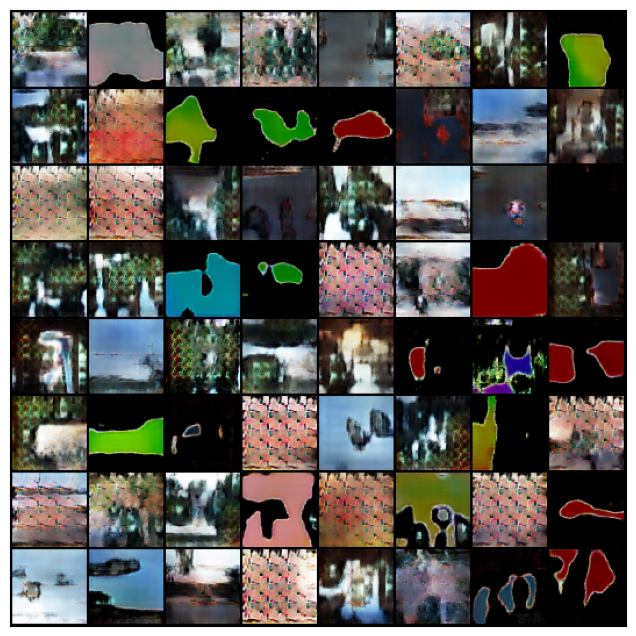

In [36]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet.

Let's move the generator to the chosen device.

In [37]:
generator = to_device(generator, device)

In [38]:
def train_discriminator(real_images, opt_d):
    real_images = real_images.to(device)  # Move input data to the same device as the model
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)

    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## c + y

In [39]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [40]:
from torchvision.utils import save_image

In [41]:
sample_dir = 'generated'
gen_label='gen_label'
os.makedirs(sample_dir, exist_ok=True)
os.makedirs(gen_label, exist_ok=True)

In [42]:
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

def save_samples(index, latent_tensors, class_name=None):
    fake_images = generator(latent_tensors)
    
    # Create a folder for the class if class_name is provided
    if class_name:
        class_folder = os.path.join(sample_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)
    else:
        class_folder = sample_dir
    
    fake_fname = f'generated-images-{index:0=4d}.jpg'
    save_image(denorm(fake_images), os.path.join(class_folder, fake_fname), nrow=8)
    print('Saving', fake_fname)

#     # Display only the five best images
#     fig, axs = plt.subplots(1, 3, figsize=(20, 4))
#     for i in range(3):
#         ax = axs[i]
#         ax.set_xticks([]); ax.set_yticks([])
# #         ax.imshow(fake_images[i].cpu().detach().permute(1, 2, 0))


We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [43]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [44]:
# save_samples(0, fixed_latent)


In [45]:
from IPython.display import Image
# Image('/kaggle/working/generated/generated-images-0000.jpg')

In [46]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [47]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr/10, betas=(0.3, 0.6))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.3, 0.6))

    for class_name in train_ds.classes:
        print(f"Training for class: {class_name}")
        # Filter dataset for the current class
        class_idx = train_ds.class_to_idx[class_name]
        indices = [i for i, (_, label) in enumerate(train_ds.imgs) if label == class_idx]
        class_subset = Subset(train_ds, indices)
        class_dl = DataLoader(class_subset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)

        for epoch in range(epochs):
            for real_images, _ in tqdm(class_dl):
                # Train discriminator
                loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
                # Train generator
                loss_g = train_generator(opt_g)

            # Record losses & scores
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            # Log losses & scores (last batch)
            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

            # Save generated images
            if (epoch + 1) % 5 == 0:
#                 save_samples(epoch+start_idx, fixed_latent, show=False)
                
                save_samples(epoch + start_idx, fixed_latent, class_name=class_name)

        # Save model for the current class
        torch.save(generator.state_dict(), f"{class_name}_generator_epoch_{epoch+1}.pt")
        torch.save(discriminator.state_dict(), f"{class_name}_discriminator_epoch_{epoch+1}.pt")
        print(f"Models saved for class: {class_name}")

    return losses_g, losses_d, real_scores, fake_scores


We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [48]:
lr = 0.0002
epochs = 25

In [49]:
history = fit(epochs, lr)

Training for class: aeroplane


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7054, loss_d: 1.4492, real_score: 0.4935, fake_score: 0.5095


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7128, loss_d: 1.3848, real_score: 0.5442, fake_score: 0.5263


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7622, loss_d: 1.3367, real_score: 0.5749, fake_score: 0.5279


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7605, loss_d: 1.2694, real_score: 0.5910, fake_score: 0.5071


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7911, loss_d: 1.2419, real_score: 0.6040, fake_score: 0.5022
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.8756, loss_d: 1.1838, real_score: 0.6111, fake_score: 0.4820


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.9325, loss_d: 1.1427, real_score: 0.6201, fake_score: 0.4663


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.9916, loss_d: 1.0999, real_score: 0.6286, fake_score: 0.4506


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.9862, loss_d: 1.0199, real_score: 0.6331, fake_score: 0.4101


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 1.0388, loss_d: 1.0261, real_score: 0.6491, fake_score: 0.4251
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 1.0325, loss_d: 0.9754, real_score: 0.6548, fake_score: 0.4040


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 1.0885, loss_d: 0.9825, real_score: 0.6596, fake_score: 0.4102


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 1.0789, loss_d: 0.9391, real_score: 0.6551, fake_score: 0.3841


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 1.0790, loss_d: 0.9201, real_score: 0.6640, fake_score: 0.3802


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 1.1044, loss_d: 0.9146, real_score: 0.6736, fake_score: 0.3859
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 1.1386, loss_d: 0.9119, real_score: 0.6756, fake_score: 0.3856


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 1.1102, loss_d: 0.9266, real_score: 0.6698, fake_score: 0.3883


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 1.1229, loss_d: 0.9153, real_score: 0.6692, fake_score: 0.3815


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 1.1712, loss_d: 0.8914, real_score: 0.6684, fake_score: 0.3682


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 1.1968, loss_d: 0.9233, real_score: 0.6726, fake_score: 0.3870
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 1.1269, loss_d: 0.8342, real_score: 0.6654, fake_score: 0.3293


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 1.2613, loss_d: 0.8905, real_score: 0.6837, fake_score: 0.3766


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 1.3187, loss_d: 0.9089, real_score: 0.6782, fake_score: 0.3842


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 1.2355, loss_d: 0.8717, real_score: 0.6613, fake_score: 0.3487


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 1.1929, loss_d: 0.8364, real_score: 0.6733, fake_score: 0.3371
Saving generated-images-0025.jpg
Models saved for class: aeroplane
Training for class: bicycle


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 1.0472, loss_d: 2.1513, real_score: 0.2256, fake_score: 0.3831


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.9292, loss_d: 1.9633, real_score: 0.2742, fake_score: 0.4101


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.8109, loss_d: 1.8481, real_score: 0.3265, fake_score: 0.4587


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7847, loss_d: 1.7435, real_score: 0.3686, fake_score: 0.4805


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7903, loss_d: 1.6290, real_score: 0.4039, fake_score: 0.4792
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.8278, loss_d: 1.6090, real_score: 0.4321, fake_score: 0.5082


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.8275, loss_d: 1.5505, real_score: 0.4515, fake_score: 0.5060


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.8053, loss_d: 1.4885, real_score: 0.4725, fake_score: 0.4982


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.8445, loss_d: 1.4526, real_score: 0.4888, fake_score: 0.5029


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.8297, loss_d: 1.3838, real_score: 0.5001, fake_score: 0.4823
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.8768, loss_d: 1.3668, real_score: 0.5096, fake_score: 0.4854


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.8747, loss_d: 1.3069, real_score: 0.5147, fake_score: 0.4559


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.9070, loss_d: 1.2733, real_score: 0.5303, fake_score: 0.4558


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.9182, loss_d: 1.2473, real_score: 0.5439, fake_score: 0.4566


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.9040, loss_d: 1.2010, real_score: 0.5567, fake_score: 0.4463
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.9453, loss_d: 1.1698, real_score: 0.5676, fake_score: 0.4412


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.9528, loss_d: 1.1558, real_score: 0.5738, fake_score: 0.4369


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.9685, loss_d: 1.1334, real_score: 0.5846, fake_score: 0.4360


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.9940, loss_d: 1.1099, real_score: 0.5857, fake_score: 0.4229


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.9950, loss_d: 1.0649, real_score: 0.5968, fake_score: 0.4079
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 1.0097, loss_d: 1.0528, real_score: 0.6101, fake_score: 0.4135


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 1.0417, loss_d: 1.0296, real_score: 0.6180, fake_score: 0.4088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 1.0821, loss_d: 1.0211, real_score: 0.6213, fake_score: 0.4068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 1.0792, loss_d: 1.0198, real_score: 0.6239, fake_score: 0.4089


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 1.0600, loss_d: 1.0059, real_score: 0.6237, fake_score: 0.3998
Saving generated-images-0025.jpg
Models saved for class: bicycle
Training for class: bird


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.8186, loss_d: 1.7743, real_score: 0.3195, fake_score: 0.4312


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7578, loss_d: 1.6241, real_score: 0.4196, fake_score: 0.5088


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7372, loss_d: 1.6201, real_score: 0.4343, fake_score: 0.5219


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7224, loss_d: 1.5011, real_score: 0.4833, fake_score: 0.5223


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7555, loss_d: 1.5118, real_score: 0.4771, fake_score: 0.5131
Saving generated-images-0005.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7284, loss_d: 1.4690, real_score: 0.5130, fake_score: 0.5332


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7470, loss_d: 1.4788, real_score: 0.5185, fake_score: 0.5393


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7608, loss_d: 1.4500, real_score: 0.5173, fake_score: 0.5304


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7285, loss_d: 1.4795, real_score: 0.5082, fake_score: 0.5337


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7580, loss_d: 1.4458, real_score: 0.5142, fake_score: 0.5281
Saving generated-images-0010.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7516, loss_d: 1.4368, real_score: 0.5193, fake_score: 0.5285


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7827, loss_d: 1.4012, real_score: 0.5203, fake_score: 0.5148


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.8101, loss_d: 1.3768, real_score: 0.5218, fake_score: 0.5020


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.8439, loss_d: 1.3110, real_score: 0.5473, fake_score: 0.4947


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.8615, loss_d: 1.2868, real_score: 0.5500, fake_score: 0.4856
Saving generated-images-0015.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.8816, loss_d: 1.3059, real_score: 0.5281, fake_score: 0.4746


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.8775, loss_d: 1.2352, real_score: 0.5597, fake_score: 0.4670


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.8786, loss_d: 1.2529, real_score: 0.5505, fake_score: 0.4648


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.8835, loss_d: 1.2725, real_score: 0.5411, fake_score: 0.4652


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.9251, loss_d: 1.2199, real_score: 0.5677, fake_score: 0.4658
Saving generated-images-0020.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.9031, loss_d: 1.2152, real_score: 0.5627, fake_score: 0.4580


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.9232, loss_d: 1.1707, real_score: 0.5729, fake_score: 0.4483


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.8974, loss_d: 1.2380, real_score: 0.5437, fake_score: 0.4548


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.9072, loss_d: 1.1598, real_score: 0.5758, fake_score: 0.4429


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.9433, loss_d: 1.1882, real_score: 0.5679, fake_score: 0.4510
Saving generated-images-0025.jpg
Models saved for class: bird
Training for class: boat


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.8070, loss_d: 1.6408, real_score: 0.3700, fake_score: 0.4421


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7498, loss_d: 1.5624, real_score: 0.4354, fake_score: 0.4898


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7128, loss_d: 1.5429, real_score: 0.4961, fake_score: 0.5386


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7076, loss_d: 1.4958, real_score: 0.5261, fake_score: 0.5443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7348, loss_d: 1.4491, real_score: 0.5372, fake_score: 0.5347
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7389, loss_d: 1.4821, real_score: 0.5400, fake_score: 0.5518


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7450, loss_d: 1.4532, real_score: 0.5326, fake_score: 0.5393


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7433, loss_d: 1.3940, real_score: 0.5293, fake_score: 0.5114


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7468, loss_d: 1.3836, real_score: 0.5379, fake_score: 0.5154


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.8290, loss_d: 1.3616, real_score: 0.5418, fake_score: 0.5100
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.8153, loss_d: 1.3419, real_score: 0.5489, fake_score: 0.5041


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7769, loss_d: 1.3127, real_score: 0.5516, fake_score: 0.4962


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.8206, loss_d: 1.3205, real_score: 0.5560, fake_score: 0.5045


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.8519, loss_d: 1.2974, real_score: 0.5530, fake_score: 0.4901


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.8725, loss_d: 1.3061, real_score: 0.5476, fake_score: 0.4921
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.8775, loss_d: 1.2706, real_score: 0.5454, fake_score: 0.4724


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.8334, loss_d: 1.2345, real_score: 0.5535, fake_score: 0.4616


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.8907, loss_d: 1.2296, real_score: 0.5663, fake_score: 0.4722


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.9549, loss_d: 1.2420, real_score: 0.5684, fake_score: 0.4782


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.8961, loss_d: 1.2077, real_score: 0.5531, fake_score: 0.4478
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.9289, loss_d: 1.2013, real_score: 0.5633, fake_score: 0.4531


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.9585, loss_d: 1.1660, real_score: 0.5656, fake_score: 0.4386


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.9359, loss_d: 1.2088, real_score: 0.5761, fake_score: 0.4705


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.9630, loss_d: 1.1558, real_score: 0.5713, fake_score: 0.4383


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.9823, loss_d: 1.1827, real_score: 0.5765, fake_score: 0.4557
Saving generated-images-0025.jpg
Models saved for class: boat
Training for class: bottle


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.8751, loss_d: 1.9886, real_score: 0.2672, fake_score: 0.4545


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7631, loss_d: 1.8347, real_score: 0.3383, fake_score: 0.4983


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.8021, loss_d: 1.6369, real_score: 0.4354, fake_score: 0.5183


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7143, loss_d: 1.8574, real_score: 0.3694, fake_score: 0.5271


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.6959, loss_d: 1.6330, real_score: 0.4623, fake_score: 0.5365
Saving generated-images-0005.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7251, loss_d: 1.6986, real_score: 0.4390, fake_score: 0.5485


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7229, loss_d: 1.6712, real_score: 0.4441, fake_score: 0.5463


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.6959, loss_d: 1.6177, real_score: 0.4627, fake_score: 0.5436


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7192, loss_d: 1.6877, real_score: 0.4601, fake_score: 0.5655


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7084, loss_d: 1.5962, real_score: 0.4725, fake_score: 0.5518
Saving generated-images-0010.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.6806, loss_d: 1.6225, real_score: 0.4524, fake_score: 0.5449


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7076, loss_d: 1.5219, real_score: 0.5107, fake_score: 0.5620


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.6835, loss_d: 1.5534, real_score: 0.4928, fake_score: 0.5559


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7396, loss_d: 1.5334, real_score: 0.4874, fake_score: 0.5413


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7468, loss_d: 1.5189, real_score: 0.4948, fake_score: 0.5449
Saving generated-images-0015.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7743, loss_d: 1.4889, real_score: 0.4809, fake_score: 0.5196


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7803, loss_d: 1.4740, real_score: 0.5017, fake_score: 0.5264


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7484, loss_d: 1.4255, real_score: 0.5038, fake_score: 0.5110


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7614, loss_d: 1.3973, real_score: 0.5204, fake_score: 0.5142


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7509, loss_d: 1.4514, real_score: 0.4855, fake_score: 0.5076
Saving generated-images-0020.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7618, loss_d: 1.4041, real_score: 0.5217, fake_score: 0.5161


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7421, loss_d: 1.4188, real_score: 0.5005, fake_score: 0.5050


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7805, loss_d: 1.4185, real_score: 0.5004, fake_score: 0.5044


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7539, loss_d: 1.4934, real_score: 0.4978, fake_score: 0.5311


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7552, loss_d: 1.3071, real_score: 0.5382, fake_score: 0.4884
Saving generated-images-0025.jpg
Models saved for class: bottle
Training for class: bus


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7075, loss_d: 1.8462, real_score: 0.3497, fake_score: 0.5199


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.6782, loss_d: 1.7256, real_score: 0.3968, fake_score: 0.5243


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.6275, loss_d: 1.6731, real_score: 0.4463, fake_score: 0.5555


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.6388, loss_d: 1.5744, real_score: 0.4840, fake_score: 0.5519


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.6970, loss_d: 1.5492, real_score: 0.5082, fake_score: 0.5618
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.6973, loss_d: 1.4950, real_score: 0.5204, fake_score: 0.5514


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7107, loss_d: 1.4719, real_score: 0.5257, fake_score: 0.5483


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7328, loss_d: 1.4578, real_score: 0.5254, fake_score: 0.5415


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7603, loss_d: 1.4073, real_score: 0.5274, fake_score: 0.5211


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7879, loss_d: 1.4270, real_score: 0.5380, fake_score: 0.5385
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7735, loss_d: 1.3652, real_score: 0.5396, fake_score: 0.5172


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7812, loss_d: 1.3209, real_score: 0.5403, fake_score: 0.4956


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.8072, loss_d: 1.2860, real_score: 0.5516, fake_score: 0.4888


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.8275, loss_d: 1.3083, real_score: 0.5605, fake_score: 0.5067


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.8552, loss_d: 1.2842, real_score: 0.5584, fake_score: 0.4921
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.8817, loss_d: 1.2424, real_score: 0.5619, fake_score: 0.4774


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.9158, loss_d: 1.2050, real_score: 0.5689, fake_score: 0.4652


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.9169, loss_d: 1.2000, real_score: 0.5724, fake_score: 0.4634


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.9503, loss_d: 1.2189, real_score: 0.5740, fake_score: 0.4749


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.9067, loss_d: 1.1569, real_score: 0.5693, fake_score: 0.4373
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.9130, loss_d: 1.1401, real_score: 0.5857, fake_score: 0.4450


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.9516, loss_d: 1.1349, real_score: 0.5956, fake_score: 0.4512


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.9381, loss_d: 1.1093, real_score: 0.5960, fake_score: 0.4373


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.9325, loss_d: 1.1037, real_score: 0.5989, fake_score: 0.4374


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.9606, loss_d: 1.0941, real_score: 0.6113, fake_score: 0.4406
Saving generated-images-0025.jpg
Models saved for class: bus
Training for class: car


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.8211, loss_d: 1.7237, real_score: 0.3699, fake_score: 0.4779


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7713, loss_d: 1.6131, real_score: 0.4235, fake_score: 0.4965


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7848, loss_d: 1.5588, real_score: 0.4482, fake_score: 0.5014


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7769, loss_d: 1.6219, real_score: 0.4606, fake_score: 0.5425


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7314, loss_d: 1.5728, real_score: 0.4533, fake_score: 0.5201
Saving generated-images-0005.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7351, loss_d: 1.5521, real_score: 0.4667, fake_score: 0.5238


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7773, loss_d: 1.5424, real_score: 0.4698, fake_score: 0.5250


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7515, loss_d: 1.5088, real_score: 0.4695, fake_score: 0.5116


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7850, loss_d: 1.5019, real_score: 0.4839, fake_score: 0.5223


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7738, loss_d: 1.4313, real_score: 0.5078, fake_score: 0.5140
Saving generated-images-0010.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7836, loss_d: 1.4023, real_score: 0.4992, fake_score: 0.4898


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.8209, loss_d: 1.4739, real_score: 0.4811, fake_score: 0.5083


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7959, loss_d: 1.4261, real_score: 0.4939, fake_score: 0.4987


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7870, loss_d: 1.3748, real_score: 0.4984, fake_score: 0.4799


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.8265, loss_d: 1.4028, real_score: 0.5167, fake_score: 0.5108
Saving generated-images-0015.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.8048, loss_d: 1.3854, real_score: 0.4942, fake_score: 0.4823


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7970, loss_d: 1.4407, real_score: 0.4988, fake_score: 0.5139


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.8143, loss_d: 1.4427, real_score: 0.4891, fake_score: 0.5043


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.8249, loss_d: 1.4214, real_score: 0.4909, fake_score: 0.4981


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.8099, loss_d: 1.3875, real_score: 0.4894, fake_score: 0.4780
Saving generated-images-0020.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.8145, loss_d: 1.3893, real_score: 0.4993, fake_score: 0.4883


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.8242, loss_d: 1.3413, real_score: 0.5243, fake_score: 0.4935


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7813, loss_d: 1.3463, real_score: 0.5069, fake_score: 0.4761


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7864, loss_d: 1.3762, real_score: 0.5158, fake_score: 0.4999


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.8364, loss_d: 1.3711, real_score: 0.5208, fake_score: 0.5019
Saving generated-images-0025.jpg
Models saved for class: car
Training for class: cat


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7845, loss_d: 1.6000, real_score: 0.3987, fake_score: 0.4767


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7258, loss_d: 1.6600, real_score: 0.4105, fake_score: 0.5132


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7058, loss_d: 1.5702, real_score: 0.4663, fake_score: 0.5305


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7041, loss_d: 1.6906, real_score: 0.4275, fake_score: 0.5453


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.6897, loss_d: 1.5709, real_score: 0.4657, fake_score: 0.5363
Saving generated-images-0005.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7241, loss_d: 1.6294, real_score: 0.4445, fake_score: 0.5389


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7167, loss_d: 1.5934, real_score: 0.4545, fake_score: 0.5318


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7117, loss_d: 1.5246, real_score: 0.4755, fake_score: 0.5282


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7093, loss_d: 1.5336, real_score: 0.4800, fake_score: 0.5401


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7446, loss_d: 1.5487, real_score: 0.4763, fake_score: 0.5418
Saving generated-images-0010.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7381, loss_d: 1.5002, real_score: 0.4884, fake_score: 0.5314


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7266, loss_d: 1.5220, real_score: 0.4779, fake_score: 0.5307


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7425, loss_d: 1.4749, real_score: 0.4952, fake_score: 0.5245


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7253, loss_d: 1.4994, real_score: 0.4600, fake_score: 0.5038


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7771, loss_d: 1.4577, real_score: 0.4971, fake_score: 0.5211
Saving generated-images-0015.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7662, loss_d: 1.4906, real_score: 0.4701, fake_score: 0.5119


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7213, loss_d: 1.4391, real_score: 0.5054, fake_score: 0.5242


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7483, loss_d: 1.4223, real_score: 0.5129, fake_score: 0.5211


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7489, loss_d: 1.4868, real_score: 0.4916, fake_score: 0.5279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7758, loss_d: 1.4534, real_score: 0.5046, fake_score: 0.5258
Saving generated-images-0020.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7795, loss_d: 1.4354, real_score: 0.4965, fake_score: 0.5112


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7644, loss_d: 1.4679, real_score: 0.4797, fake_score: 0.5076


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7639, loss_d: 1.4260, real_score: 0.5178, fake_score: 0.5247


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7518, loss_d: 1.4561, real_score: 0.4829, fake_score: 0.5088


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7705, loss_d: 1.4488, real_score: 0.4933, fake_score: 0.5169
Saving generated-images-0025.jpg
Models saved for class: cat
Training for class: chair


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7241, loss_d: 1.6604, real_score: 0.4114, fake_score: 0.5260


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7077, loss_d: 1.6671, real_score: 0.4408, fake_score: 0.5592


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7214, loss_d: 1.6433, real_score: 0.4492, fake_score: 0.5584


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7409, loss_d: 1.5438, real_score: 0.4638, fake_score: 0.5304


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7595, loss_d: 1.5332, real_score: 0.4655, fake_score: 0.5267
Saving generated-images-0005.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7497, loss_d: 1.4936, real_score: 0.4805, fake_score: 0.5229


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7308, loss_d: 1.5084, real_score: 0.4772, fake_score: 0.5255


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7791, loss_d: 1.5242, real_score: 0.4788, fake_score: 0.5364


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7435, loss_d: 1.4828, real_score: 0.4965, fake_score: 0.5345


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7580, loss_d: 1.4956, real_score: 0.4812, fake_score: 0.5263
Saving generated-images-0010.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7478, loss_d: 1.4599, real_score: 0.4852, fake_score: 0.5129


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7727, loss_d: 1.4286, real_score: 0.4943, fake_score: 0.5056


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7565, loss_d: 1.4456, real_score: 0.4942, fake_score: 0.5144


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7717, loss_d: 1.4189, real_score: 0.5118, fake_score: 0.5184


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7760, loss_d: 1.4134, real_score: 0.5088, fake_score: 0.5113
Saving generated-images-0015.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7419, loss_d: 1.4103, real_score: 0.4942, fake_score: 0.4970


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7594, loss_d: 1.4266, real_score: 0.5089, fake_score: 0.5196


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7718, loss_d: 1.4427, real_score: 0.5060, fake_score: 0.5239


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7590, loss_d: 1.4444, real_score: 0.4915, fake_score: 0.5112


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7534, loss_d: 1.4029, real_score: 0.5059, fake_score: 0.5067
Saving generated-images-0020.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7562, loss_d: 1.4339, real_score: 0.5202, fake_score: 0.5335


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7617, loss_d: 1.4399, real_score: 0.5001, fake_score: 0.5169


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7504, loss_d: 1.4384, real_score: 0.4934, fake_score: 0.5105


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7701, loss_d: 1.4051, real_score: 0.5095, fake_score: 0.5096


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7967, loss_d: 1.3745, real_score: 0.5050, fake_score: 0.4925
Saving generated-images-0025.jpg
Models saved for class: chair
Training for class: cow


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7503, loss_d: 1.5879, real_score: 0.4121, fake_score: 0.4921


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7324, loss_d: 1.5406, real_score: 0.4611, fake_score: 0.5239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7108, loss_d: 1.4897, real_score: 0.4991, fake_score: 0.5379


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7325, loss_d: 1.4557, real_score: 0.5175, fake_score: 0.5400


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7376, loss_d: 1.4189, real_score: 0.5243, fake_score: 0.5288
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7647, loss_d: 1.4130, real_score: 0.5333, fake_score: 0.5347


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7782, loss_d: 1.3605, real_score: 0.5341, fake_score: 0.5112


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7941, loss_d: 1.3326, real_score: 0.5338, fake_score: 0.4979


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.8055, loss_d: 1.3328, real_score: 0.5432, fake_score: 0.5067


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.8323, loss_d: 1.3114, real_score: 0.5466, fake_score: 0.4993
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.8429, loss_d: 1.2863, real_score: 0.5520, fake_score: 0.4918


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.8203, loss_d: 1.2866, real_score: 0.5599, fake_score: 0.4974


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.8240, loss_d: 1.2863, real_score: 0.5662, fake_score: 0.5036


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.8313, loss_d: 1.2142, real_score: 0.5665, fake_score: 0.4681


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.8463, loss_d: 1.2223, real_score: 0.5820, fake_score: 0.4864
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.8745, loss_d: 1.2165, real_score: 0.5799, fake_score: 0.4812


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.8913, loss_d: 1.2098, real_score: 0.5734, fake_score: 0.4705


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.8936, loss_d: 1.1855, real_score: 0.5779, fake_score: 0.4633


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.8954, loss_d: 1.1482, real_score: 0.5798, fake_score: 0.4446


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.9188, loss_d: 1.1641, real_score: 0.5865, fake_score: 0.4573
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.9196, loss_d: 1.1358, real_score: 0.5950, fake_score: 0.4507


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.9265, loss_d: 1.1283, real_score: 0.6021, fake_score: 0.4556


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.9338, loss_d: 1.0895, real_score: 0.6002, fake_score: 0.4317


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.9289, loss_d: 1.0942, real_score: 0.6018, fake_score: 0.4363


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.9293, loss_d: 1.0798, real_score: 0.6118, fake_score: 0.4370
Saving generated-images-0025.jpg
Models saved for class: cow
Training for class: diningtable


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.9077, loss_d: 1.7242, real_score: 0.3377, fake_score: 0.4539


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.9001, loss_d: 1.6021, real_score: 0.3743, fake_score: 0.4467


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.8517, loss_d: 1.5213, real_score: 0.4151, fake_score: 0.4567


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.8229, loss_d: 1.4731, real_score: 0.4512, fake_score: 0.4742


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7978, loss_d: 1.4637, real_score: 0.4759, fake_score: 0.4912
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.8080, loss_d: 1.4748, real_score: 0.4935, fake_score: 0.5089


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7869, loss_d: 1.5033, real_score: 0.5027, fake_score: 0.5335


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7579, loss_d: 1.4413, real_score: 0.5038, fake_score: 0.5129


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7992, loss_d: 1.4906, real_score: 0.5065, fake_score: 0.5372


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7742, loss_d: 1.4720, real_score: 0.5023, fake_score: 0.5289
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7832, loss_d: 1.4919, real_score: 0.4981, fake_score: 0.5338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7720, loss_d: 1.4913, real_score: 0.4980, fake_score: 0.5359


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7807, loss_d: 1.4831, real_score: 0.4976, fake_score: 0.5326


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7761, loss_d: 1.4653, real_score: 0.4990, fake_score: 0.5260


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7826, loss_d: 1.4561, real_score: 0.5021, fake_score: 0.5246
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7836, loss_d: 1.4407, real_score: 0.5071, fake_score: 0.5240


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.8141, loss_d: 1.4000, real_score: 0.5081, fake_score: 0.5059


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.8028, loss_d: 1.4083, real_score: 0.5115, fake_score: 0.5138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.8044, loss_d: 1.3968, real_score: 0.5149, fake_score: 0.5115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.8422, loss_d: 1.3814, real_score: 0.5176, fake_score: 0.5063
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7700, loss_d: 1.3498, real_score: 0.5211, fake_score: 0.4951


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7932, loss_d: 1.3755, real_score: 0.5252, fake_score: 0.5112


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7847, loss_d: 1.3742, real_score: 0.5285, fake_score: 0.5137


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7875, loss_d: 1.3567, real_score: 0.5278, fake_score: 0.5046


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.8119, loss_d: 1.3780, real_score: 0.5263, fake_score: 0.5131
Saving generated-images-0025.jpg
Models saved for class: diningtable
Training for class: dog


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7637, loss_d: 1.6730, real_score: 0.4041, fake_score: 0.5155


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7676, loss_d: 1.6121, real_score: 0.4445, fake_score: 0.5337


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7496, loss_d: 1.5267, real_score: 0.4670, fake_score: 0.5234


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7376, loss_d: 1.5874, real_score: 0.4574, fake_score: 0.5386


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7279, loss_d: 1.5475, real_score: 0.4713, fake_score: 0.5374
Saving generated-images-0005.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7408, loss_d: 1.4989, real_score: 0.4897, fake_score: 0.5331


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7396, loss_d: 1.4902, real_score: 0.4944, fake_score: 0.5337


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7813, loss_d: 1.4831, real_score: 0.4938, fake_score: 0.5320


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7641, loss_d: 1.4731, real_score: 0.4835, fake_score: 0.5162


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7558, loss_d: 1.5098, real_score: 0.4724, fake_score: 0.5209
Saving generated-images-0010.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7583, loss_d: 1.4942, real_score: 0.4813, fake_score: 0.5265


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7579, loss_d: 1.4809, real_score: 0.4862, fake_score: 0.5238


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7596, loss_d: 1.4844, real_score: 0.4777, fake_score: 0.5169


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7319, loss_d: 1.4443, real_score: 0.4934, fake_score: 0.5139


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7345, loss_d: 1.4916, real_score: 0.4741, fake_score: 0.5170
Saving generated-images-0015.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7642, loss_d: 1.4360, real_score: 0.4941, fake_score: 0.5120


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7675, loss_d: 1.4458, real_score: 0.4913, fake_score: 0.5118


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7824, loss_d: 1.4288, real_score: 0.4963, fake_score: 0.5092


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7791, loss_d: 1.4456, real_score: 0.4878, fake_score: 0.5083


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7730, loss_d: 1.3992, real_score: 0.4980, fake_score: 0.4967
Saving generated-images-0020.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7573, loss_d: 1.4108, real_score: 0.4921, fake_score: 0.4957


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7567, loss_d: 1.4408, real_score: 0.4887, fake_score: 0.5084


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7551, loss_d: 1.4603, real_score: 0.4771, fake_score: 0.5059


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7606, loss_d: 1.4199, real_score: 0.4964, fake_score: 0.5064


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7277, loss_d: 1.4324, real_score: 0.4881, fake_score: 0.5047
Saving generated-images-0025.jpg
Models saved for class: dog
Training for class: horse


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7199, loss_d: 1.5873, real_score: 0.4198, fake_score: 0.5029


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7121, loss_d: 1.5564, real_score: 0.4581, fake_score: 0.5264


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.6942, loss_d: 1.5073, real_score: 0.4777, fake_score: 0.5240


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7201, loss_d: 1.5265, real_score: 0.4881, fake_score: 0.5429


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7330, loss_d: 1.4823, real_score: 0.4877, fake_score: 0.5220
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7091, loss_d: 1.4755, real_score: 0.4916, fake_score: 0.5239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7405, loss_d: 1.4958, real_score: 0.4992, fake_score: 0.5415


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7444, loss_d: 1.4371, real_score: 0.4914, fake_score: 0.5080


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7589, loss_d: 1.4431, real_score: 0.4987, fake_score: 0.5182


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7863, loss_d: 1.4203, real_score: 0.5016, fake_score: 0.5106
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.8123, loss_d: 1.4276, real_score: 0.4949, fake_score: 0.5089


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7975, loss_d: 1.3886, real_score: 0.4941, fake_score: 0.4900


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7613, loss_d: 1.3807, real_score: 0.5049, fake_score: 0.4971


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7614, loss_d: 1.3719, real_score: 0.5168, fake_score: 0.5037


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7561, loss_d: 1.3591, real_score: 0.5194, fake_score: 0.4995
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7918, loss_d: 1.3802, real_score: 0.5177, fake_score: 0.5073


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7852, loss_d: 1.3214, real_score: 0.5101, fake_score: 0.4715


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7849, loss_d: 1.3477, real_score: 0.5265, fake_score: 0.5009


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.8055, loss_d: 1.3232, real_score: 0.5231, fake_score: 0.4864


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7986, loss_d: 1.3529, real_score: 0.5124, fake_score: 0.4883
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7469, loss_d: 1.3412, real_score: 0.5172, fake_score: 0.4884


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7954, loss_d: 1.3582, real_score: 0.5259, fake_score: 0.5058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.8159, loss_d: 1.3608, real_score: 0.5207, fake_score: 0.5012


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.8047, loss_d: 1.3394, real_score: 0.5192, fake_score: 0.4881


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7969, loss_d: 1.3413, real_score: 0.5208, fake_score: 0.4904
Saving generated-images-0025.jpg
Models saved for class: horse
Training for class: motorbike


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7643, loss_d: 1.5779, real_score: 0.4108, fake_score: 0.4853


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7471, loss_d: 1.5400, real_score: 0.4449, fake_score: 0.5074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7558, loss_d: 1.5166, real_score: 0.4642, fake_score: 0.5165


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7540, loss_d: 1.4784, real_score: 0.4687, fake_score: 0.5025


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7475, loss_d: 1.4619, real_score: 0.4805, fake_score: 0.5074
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7408, loss_d: 1.4657, real_score: 0.4917, fake_score: 0.5198


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7604, loss_d: 1.4461, real_score: 0.4975, fake_score: 0.5164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7535, loss_d: 1.4194, real_score: 0.4975, fake_score: 0.5063


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7363, loss_d: 1.4074, real_score: 0.4973, fake_score: 0.4995


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7872, loss_d: 1.4177, real_score: 0.5050, fake_score: 0.5105
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7876, loss_d: 1.4031, real_score: 0.4973, fake_score: 0.4959


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7264, loss_d: 1.3981, real_score: 0.4947, fake_score: 0.4914


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7771, loss_d: 1.4363, real_score: 0.5075, fake_score: 0.5226


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7795, loss_d: 1.3971, real_score: 0.5002, fake_score: 0.4976


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7601, loss_d: 1.4042, real_score: 0.4990, fake_score: 0.4986
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7556, loss_d: 1.3895, real_score: 0.5051, fake_score: 0.4980


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7731, loss_d: 1.3699, real_score: 0.5102, fake_score: 0.4933


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7695, loss_d: 1.3813, real_score: 0.5111, fake_score: 0.5005


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7880, loss_d: 1.3729, real_score: 0.5051, fake_score: 0.4897


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7518, loss_d: 1.3869, real_score: 0.5100, fake_score: 0.5016
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7961, loss_d: 1.3707, real_score: 0.5196, fake_score: 0.5046


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7837, loss_d: 1.3970, real_score: 0.5109, fake_score: 0.5084


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7843, loss_d: 1.3819, real_score: 0.5080, fake_score: 0.4993


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7861, loss_d: 1.3762, real_score: 0.5113, fake_score: 0.5004


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7777, loss_d: 1.3915, real_score: 0.5100, fake_score: 0.5069
Saving generated-images-0025.jpg
Models saved for class: motorbike
Training for class: person


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.6742, loss_d: 1.5283, real_score: 0.4799, fake_score: 0.5406


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7149, loss_d: 1.4972, real_score: 0.4641, fake_score: 0.5102


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.6868, loss_d: 1.4941, real_score: 0.4956, fake_score: 0.5399


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.6947, loss_d: 1.4775, real_score: 0.5051, fake_score: 0.5396


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7347, loss_d: 1.4297, real_score: 0.4954, fake_score: 0.5110
Saving generated-images-0005.jpg


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7211, loss_d: 1.4964, real_score: 0.4816, fake_score: 0.5291


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7041, loss_d: 1.4837, real_score: 0.4648, fake_score: 0.5069


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7322, loss_d: 1.5391, real_score: 0.4648, fake_score: 0.5327


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7243, loss_d: 1.4720, real_score: 0.4830, fake_score: 0.5204


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7175, loss_d: 1.4376, real_score: 0.4991, fake_score: 0.5189
Saving generated-images-0010.jpg


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.6959, loss_d: 1.4546, real_score: 0.4840, fake_score: 0.5104


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.6896, loss_d: 1.4782, real_score: 0.4907, fake_score: 0.5301


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7090, loss_d: 1.4799, real_score: 0.4819, fake_score: 0.5219


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7397, loss_d: 1.4407, real_score: 0.4988, fake_score: 0.5202


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7324, loss_d: 1.4214, real_score: 0.4945, fake_score: 0.5069
Saving generated-images-0015.jpg


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7019, loss_d: 1.4440, real_score: 0.4825, fake_score: 0.5061


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7076, loss_d: 1.4306, real_score: 0.4964, fake_score: 0.5126


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7068, loss_d: 1.4276, real_score: 0.4986, fake_score: 0.5130


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7208, loss_d: 1.4369, real_score: 0.4829, fake_score: 0.5031


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7480, loss_d: 1.4495, real_score: 0.4823, fake_score: 0.5076
Saving generated-images-0020.jpg


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7239, loss_d: 1.4348, real_score: 0.4949, fake_score: 0.5147


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7328, loss_d: 1.4333, real_score: 0.4995, fake_score: 0.5172


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7270, loss_d: 1.4393, real_score: 0.4789, fake_score: 0.5001


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7060, loss_d: 1.4651, real_score: 0.4731, fake_score: 0.5047


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7265, loss_d: 1.4087, real_score: 0.4835, fake_score: 0.4906
Saving generated-images-0025.jpg
Models saved for class: person
Training for class: pottedplant


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7173, loss_d: 1.4103, real_score: 0.4904, fake_score: 0.4963


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7288, loss_d: 1.4298, real_score: 0.4989, fake_score: 0.5124


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7491, loss_d: 1.4254, real_score: 0.4936, fake_score: 0.5077


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7806, loss_d: 1.4238, real_score: 0.4845, fake_score: 0.4980


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7760, loss_d: 1.4308, real_score: 0.4824, fake_score: 0.4993
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7601, loss_d: 1.4295, real_score: 0.4848, fake_score: 0.4992


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7478, loss_d: 1.4132, real_score: 0.4902, fake_score: 0.4964


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7500, loss_d: 1.4103, real_score: 0.5003, fake_score: 0.5057


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7402, loss_d: 1.4075, real_score: 0.5048, fake_score: 0.5107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7382, loss_d: 1.3880, real_score: 0.5094, fake_score: 0.5051
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7645, loss_d: 1.3865, real_score: 0.5098, fake_score: 0.5035


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7800, loss_d: 1.3685, real_score: 0.5005, fake_score: 0.4853


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7936, loss_d: 1.3509, real_score: 0.4978, fake_score: 0.4740


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7697, loss_d: 1.3614, real_score: 0.5022, fake_score: 0.4839


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7570, loss_d: 1.3623, real_score: 0.5067, fake_score: 0.4896
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7401, loss_d: 1.3770, real_score: 0.5154, fake_score: 0.5058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7302, loss_d: 1.3527, real_score: 0.5220, fake_score: 0.4998


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7561, loss_d: 1.3604, real_score: 0.5293, fake_score: 0.5097


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7507, loss_d: 1.3416, real_score: 0.5290, fake_score: 0.4996


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7826, loss_d: 1.3424, real_score: 0.5300, fake_score: 0.5016
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7884, loss_d: 1.3368, real_score: 0.5240, fake_score: 0.4948


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7843, loss_d: 1.3194, real_score: 0.5206, fake_score: 0.4820


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7627, loss_d: 1.3449, real_score: 0.5188, fake_score: 0.4921


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7738, loss_d: 1.3503, real_score: 0.5224, fake_score: 0.4990


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7686, loss_d: 1.3360, real_score: 0.5258, fake_score: 0.4954
Saving generated-images-0025.jpg
Models saved for class: pottedplant
Training for class: sheep


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7178, loss_d: 1.4915, real_score: 0.4566, fake_score: 0.5020


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.6939, loss_d: 1.4645, real_score: 0.4974, fake_score: 0.5270


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7042, loss_d: 1.4251, real_score: 0.5147, fake_score: 0.5244


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7296, loss_d: 1.4435, real_score: 0.5218, fake_score: 0.5382


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7651, loss_d: 1.4065, real_score: 0.5098, fake_score: 0.5146
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7553, loss_d: 1.3795, real_score: 0.5002, fake_score: 0.4924


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7320, loss_d: 1.3669, real_score: 0.5080, fake_score: 0.4947


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7370, loss_d: 1.3687, real_score: 0.5272, fake_score: 0.5135


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7595, loss_d: 1.3555, real_score: 0.5239, fake_score: 0.5043


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7482, loss_d: 1.3373, real_score: 0.5194, fake_score: 0.4902
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7939, loss_d: 1.3355, real_score: 0.5253, fake_score: 0.4954


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7869, loss_d: 1.3183, real_score: 0.5186, fake_score: 0.4805


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7794, loss_d: 1.3004, real_score: 0.5220, fake_score: 0.4748


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7946, loss_d: 1.2922, real_score: 0.5288, fake_score: 0.4780


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.8273, loss_d: 1.2914, real_score: 0.5334, fake_score: 0.4818
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7897, loss_d: 1.2632, real_score: 0.5230, fake_score: 0.4555


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.8258, loss_d: 1.2659, real_score: 0.5354, fake_score: 0.4695


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.8047, loss_d: 1.2525, real_score: 0.5339, fake_score: 0.4604


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.8361, loss_d: 1.2340, real_score: 0.5451, fake_score: 0.4611


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.8119, loss_d: 1.2370, real_score: 0.5443, fake_score: 0.4615
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.8435, loss_d: 1.2202, real_score: 0.5571, fake_score: 0.4656


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.8073, loss_d: 1.2294, real_score: 0.5505, fake_score: 0.4633


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.8052, loss_d: 1.2089, real_score: 0.5648, fake_score: 0.4673


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.8158, loss_d: 1.2070, real_score: 0.5610, fake_score: 0.4622


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.8127, loss_d: 1.2125, real_score: 0.5631, fake_score: 0.4678
Saving generated-images-0025.jpg
Models saved for class: sheep
Training for class: sofa


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7785, loss_d: 1.5379, real_score: 0.4055, fake_score: 0.4618


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.7565, loss_d: 1.4991, real_score: 0.4339, fake_score: 0.4770


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7371, loss_d: 1.4740, real_score: 0.4639, fake_score: 0.4987


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7557, loss_d: 1.4699, real_score: 0.4837, fake_score: 0.5161


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7444, loss_d: 1.4196, real_score: 0.4903, fake_score: 0.4995
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7612, loss_d: 1.4156, real_score: 0.4956, fake_score: 0.5027


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7819, loss_d: 1.4005, real_score: 0.5000, fake_score: 0.4993


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7635, loss_d: 1.3955, real_score: 0.5002, fake_score: 0.4973


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7704, loss_d: 1.3824, real_score: 0.5025, fake_score: 0.4936


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7751, loss_d: 1.3462, real_score: 0.5147, fake_score: 0.4888
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7581, loss_d: 1.3525, real_score: 0.5179, fake_score: 0.4942


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7750, loss_d: 1.3391, real_score: 0.5209, fake_score: 0.4900


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7852, loss_d: 1.3468, real_score: 0.5148, fake_score: 0.4885


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.8055, loss_d: 1.3668, real_score: 0.5084, fake_score: 0.4911


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7793, loss_d: 1.3675, real_score: 0.5014, fake_score: 0.4849
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7981, loss_d: 1.3592, real_score: 0.5075, fake_score: 0.4882


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7850, loss_d: 1.3549, real_score: 0.5105, fake_score: 0.4893


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7725, loss_d: 1.3465, real_score: 0.5145, fake_score: 0.4884


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7934, loss_d: 1.3764, real_score: 0.5209, fake_score: 0.5068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.8099, loss_d: 1.3698, real_score: 0.5093, fake_score: 0.4940
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7787, loss_d: 1.3614, real_score: 0.5041, fake_score: 0.4855


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7753, loss_d: 1.3468, real_score: 0.5089, fake_score: 0.4829


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7707, loss_d: 1.3849, real_score: 0.5167, fake_score: 0.5080


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7572, loss_d: 1.3545, real_score: 0.5167, fake_score: 0.4946


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7552, loss_d: 1.3391, real_score: 0.5182, fake_score: 0.4885
Saving generated-images-0025.jpg
Models saved for class: sofa
Training for class: train


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.7004, loss_d: 1.4901, real_score: 0.4561, fake_score: 0.4987


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.6498, loss_d: 1.4282, real_score: 0.5219, fake_score: 0.5306


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.7069, loss_d: 1.4111, real_score: 0.5592, fake_score: 0.5462


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.7147, loss_d: 1.3910, real_score: 0.5568, fake_score: 0.5340


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7137, loss_d: 1.4222, real_score: 0.5378, fake_score: 0.5336
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7150, loss_d: 1.4535, real_score: 0.5196, fake_score: 0.5360


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7604, loss_d: 1.4736, real_score: 0.5029, fake_score: 0.5326


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7372, loss_d: 1.4543, real_score: 0.4782, fake_score: 0.5034


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.7495, loss_d: 1.4314, real_score: 0.4891, fake_score: 0.5043


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7482, loss_d: 1.4264, real_score: 0.4843, fake_score: 0.4992
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7203, loss_d: 1.4140, real_score: 0.4820, fake_score: 0.4911


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7251, loss_d: 1.4022, real_score: 0.5085, fake_score: 0.5115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7795, loss_d: 1.3872, real_score: 0.5084, fake_score: 0.5047


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7841, loss_d: 1.3944, real_score: 0.4925, fake_score: 0.4915


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7656, loss_d: 1.3941, real_score: 0.4862, fake_score: 0.4831
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7334, loss_d: 1.3820, real_score: 0.5006, fake_score: 0.4932


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7659, loss_d: 1.3879, real_score: 0.5054, fake_score: 0.4998


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7170, loss_d: 1.4030, real_score: 0.4934, fake_score: 0.4949


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7426, loss_d: 1.4068, real_score: 0.5183, fake_score: 0.5223


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7535, loss_d: 1.3725, real_score: 0.5076, fake_score: 0.4959
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7514, loss_d: 1.3483, real_score: 0.5171, fake_score: 0.4935


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7849, loss_d: 1.3389, real_score: 0.5297, fake_score: 0.5014


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7830, loss_d: 1.3361, real_score: 0.5133, fake_score: 0.4834


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7538, loss_d: 1.3484, real_score: 0.5126, fake_score: 0.4881


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7433, loss_d: 1.3455, real_score: 0.5152, fake_score: 0.4898
Saving generated-images-0025.jpg
Models saved for class: train
Training for class: tvmonitor


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 0.8282, loss_d: 1.5150, real_score: 0.4462, fake_score: 0.5010


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 0.8616, loss_d: 1.4802, real_score: 0.4385, fake_score: 0.4743


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 0.8458, loss_d: 1.4223, real_score: 0.4461, fake_score: 0.4515


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 0.8443, loss_d: 1.3988, real_score: 0.4653, fake_score: 0.4589


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 0.7831, loss_d: 1.3776, real_score: 0.4842, fake_score: 0.4673
Saving generated-images-0005.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 0.7592, loss_d: 1.3788, real_score: 0.4981, fake_score: 0.4840


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 0.7513, loss_d: 1.3840, real_score: 0.5077, fake_score: 0.4942


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 0.7573, loss_d: 1.3353, real_score: 0.5171, fake_score: 0.4810


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 0.8081, loss_d: 1.3659, real_score: 0.5197, fake_score: 0.4949


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 0.7798, loss_d: 1.3569, real_score: 0.5207, fake_score: 0.4936
Saving generated-images-0010.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.7774, loss_d: 1.3486, real_score: 0.5196, fake_score: 0.4891


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.7815, loss_d: 1.3841, real_score: 0.5124, fake_score: 0.4972


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 0.7747, loss_d: 1.3359, real_score: 0.5096, fake_score: 0.4737


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 0.7567, loss_d: 1.3885, real_score: 0.5146, fake_score: 0.5047


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 0.7452, loss_d: 1.3703, real_score: 0.5237, fake_score: 0.5063
Saving generated-images-0015.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 0.7645, loss_d: 1.3639, real_score: 0.5275, fake_score: 0.5073


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 0.7484, loss_d: 1.3525, real_score: 0.5239, fake_score: 0.4994


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 0.7954, loss_d: 1.3278, real_score: 0.5199, fake_score: 0.4831


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.7746, loss_d: 1.3227, real_score: 0.5278, fake_score: 0.4888


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.7470, loss_d: 1.3142, real_score: 0.5292, fake_score: 0.4854
Saving generated-images-0020.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 0.7624, loss_d: 1.3152, real_score: 0.5378, fake_score: 0.4927


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 0.7580, loss_d: 1.3222, real_score: 0.5344, fake_score: 0.4935


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 0.7625, loss_d: 1.3219, real_score: 0.5310, fake_score: 0.4886


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 0.7917, loss_d: 1.3320, real_score: 0.5225, fake_score: 0.4877


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 0.7512, loss_d: 1.3215, real_score: 0.5240, fake_score: 0.4855
Saving generated-images-0025.jpg
Models saved for class: tvmonitor


In [50]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

In [51]:
import torch.nn as nn

# Initialize final discriminator and generator
final_discriminator = discriminator  # Assuming Discriminator is your discriminator model class
final_generator = generator          # Assuming Generator is your generator model class

# Concatenate parameters of discriminator and generator from each class
for class_name in train_ds.classes:
    # Load discriminator and generator models for the current class
    discriminator_state_dict = torch.load(f"{class_name}_discriminator_epoch_{epochs}.pt")
    generator_state_dict = torch.load(f"{class_name}_generator_epoch_{epochs}.pt")
    
    # Update final discriminator and generator parameters
    final_discriminator.load_state_dict(discriminator_state_dict, strict=False)
    final_generator.load_state_dict(generator_state_dict, strict=False)

# Set final discriminator and generator to evaluation mode
final_discriminator.eval()
final_generator.eval()


Sequential(
  (0): ConvTranspose2d(120, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [52]:
# Save final discriminator and generator checkpoints
torch.save(final_generator.state_dict(), 'final_G9.pth')
torch.save(final_discriminator.state_dict(), 'final_D9.pth')


Here's how the generated images look, after different epochs of training.

In [53]:
from IPython.display import Image

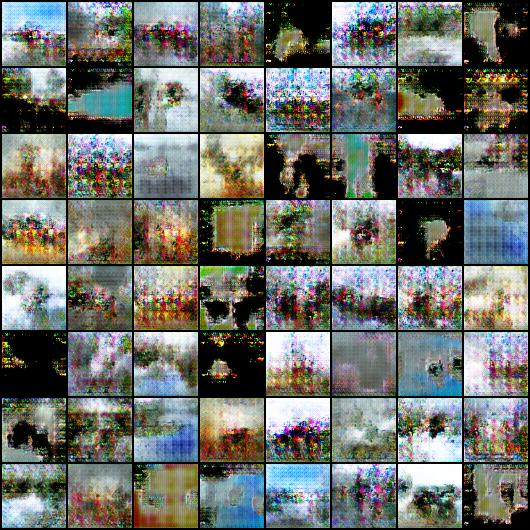

In [54]:
Image('/kaggle/working/generated/boat/generated-images-0025.jpg')

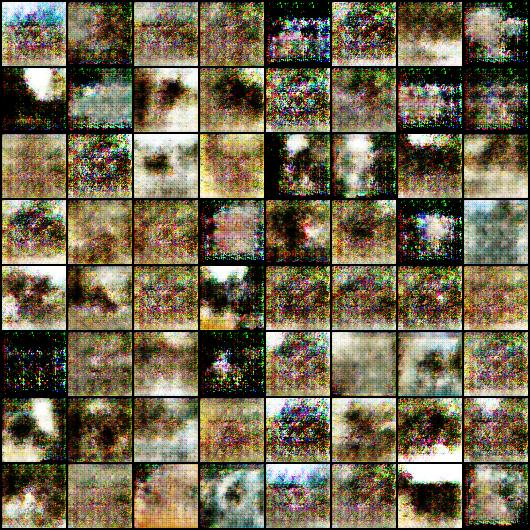

In [55]:
Image('/kaggle/working/generated/horse/generated-images-0025.jpg')

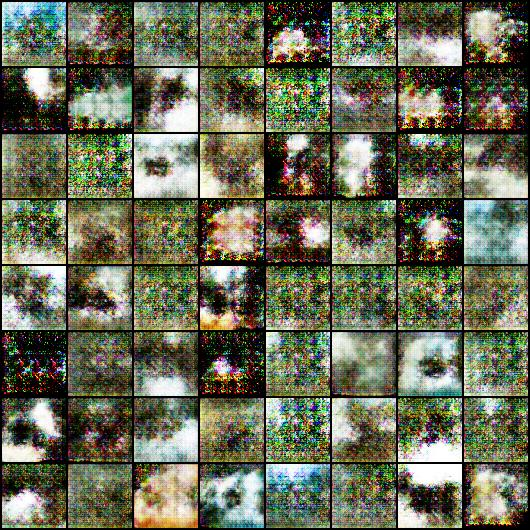

In [56]:
Image('/kaggle/working/generated/dog/generated-images-0025.jpg')

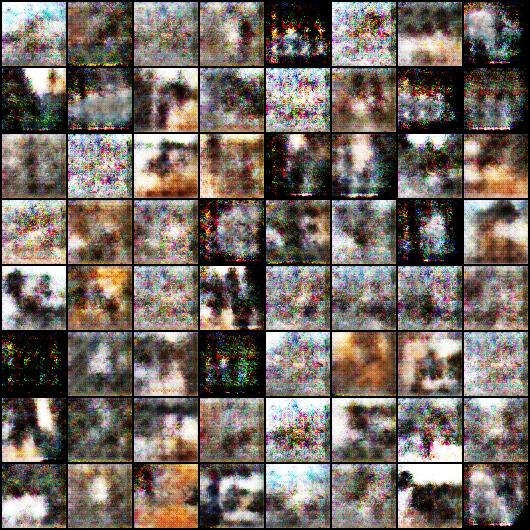

In [57]:
Image('/kaggle/working/generated/person/generated-images-0025.jpg')

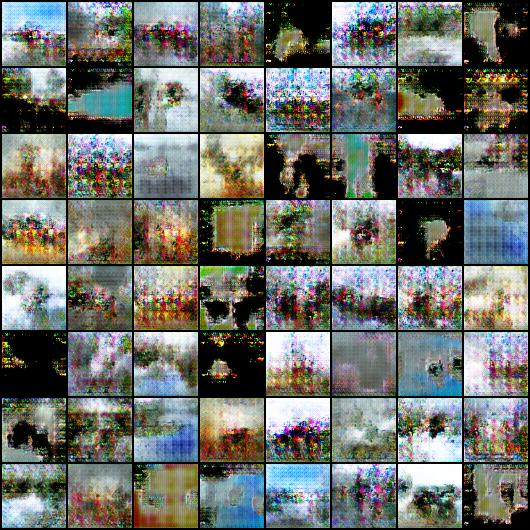

In [58]:
Image('/kaggle/working/generated/boat/generated-images-0025.jpg')

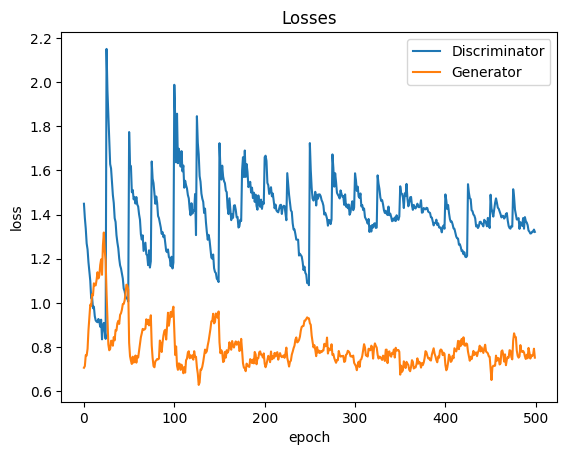

In [59]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

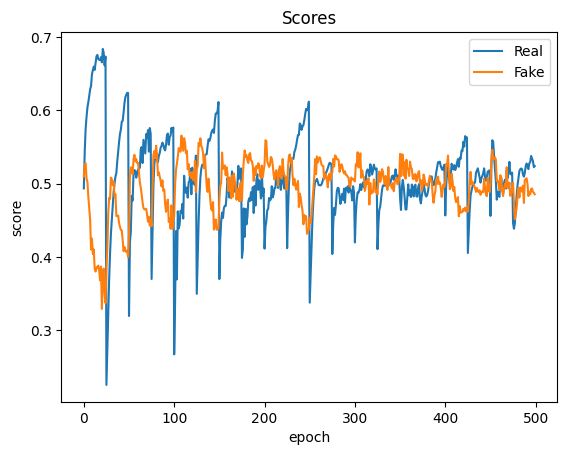

In [60]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');